In [127]:
import wisardpkg as wp

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import librosa
import librosa.display
import os
import fnmatch
import scipy.stats as stats

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from random import random
from sklearn.preprocessing import OneHotEncoder

In [128]:
set_a = pd.read_csv("heart_sounds/set_a.csv")
set_a_timing = pd.read_csv("heart_sounds/set_a.csv")
set_b = pd.read_csv("heart_sounds/set_b.csv")

In [129]:
#merge both set-a and set-b
dataframes = [set_a, set_b]
train_ab = pd.concat(dataframes)
train_ab.describe()

dataset                                           fname   label  \
count      832                                             832     585   
unique       2                                             832       5   
top          b  set_b/Btraining_normal_294_1311681084248_B.wav  normal   
freq       656                                               1     351   

           sublabel  
count           149  
unique            2  
top     noisynormal  
freq            120

In [130]:
#get all unique labels
nb_classes=train_ab.label.unique()

Min samples per category =  19
Max samples per category =  351


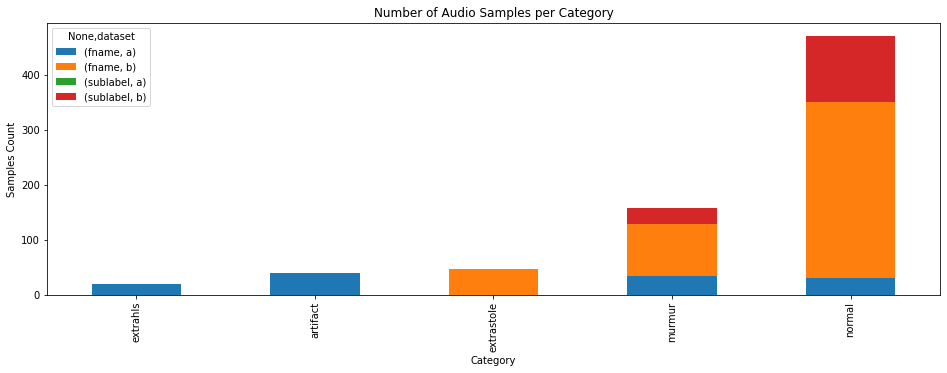

In [131]:
# visualize data distribution by category
category_group = train_ab.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");

print('Min samples per category = ', min(train_ab.label.value_counts()))
print('Max samples per category = ', max(train_ab.label.value_counts()))

In [132]:
# Testing mfccs
y, sr = librosa.load('heart_sounds/set_a/normal__201108011118.wav')
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

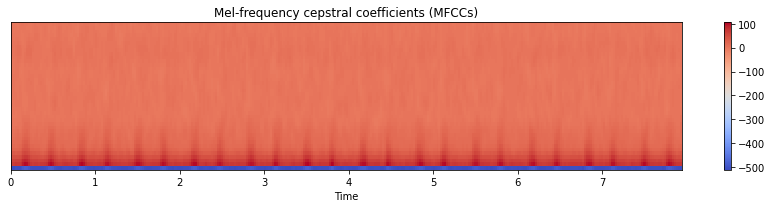

In [133]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

In [135]:
def load_file_data(folder, file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load(sound_file, sr=sr, duration=duration, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                #print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio           
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0) 
            mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T
            kc = wp.KernelCanvas(len(mfccs[0]), 50)
            out = kc.transform(mfccs) 
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        feature = np.array(out).reshape([-1,1])
        #feature = np.array(out)
        data.append(feature)
    return data

def load_file_data_sum(folder, file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            X, sr = librosa.load( sound_file, sr=sr, duration=duration, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            if (round(dur) < duration):
                y = librosa.util.fix_length(X, input_length)  
            mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40)               
            mfccs_sum = np.cumsum(mfccs, axis=1)
            mfccs_zscore = stats.zscore(mfccs_sum)
            mfccs_tanh = np.tanh(mfccs_zscore)
            kc = wp.KernelCanvas(len(mfccs_tanh[0]), 50)
            out = kc.transform(mfccs_tanh)  
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        data.append(out)
    return data

In [136]:
input_dir = 'heart_sounds'
A_folder = input_dir+'/set_a/'

A_artifact_files = fnmatch.filter(os.listdir(input_dir+'/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data_sum(folder=A_folder, file_names=A_artifact_files, duration=5)
A_artifact_labels = ['artifact' for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir(input_dir+'/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data_sum(folder=A_folder, file_names=A_normal_files, duration=5)
A_normal_labels = ['normal' for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(input_dir+'/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data_sum(folder=A_folder, file_names=A_extrahls_files, duration=5)
A_extrahls_labels = ['extrahls' for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(input_dir+'/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data_sum(folder=A_folder, file_names=A_murmur_files, duration=5)
A_murmur_labels = ['murmur' for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(input_dir+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data_sum(folder=A_folder,file_names=A_unlabelledtest_files, duration=5)
A_unlabelledtest_labels = ['unlabelledtest' for items in A_unlabelledtest_sounds]


In [137]:
input_dir = 'heart_sounds'
B_folder = input_dir+'/set_b/'

B_normal_files = fnmatch.filter(os.listdir(input_dir+'/set_b'), 'normal*.wav')
B_normal_sounds = load_file_data_sum(folder=B_folder, file_names=B_normal_files, duration=5)
B_normal_labels = ['normal' for items in B_normal_sounds]

B_extrastole_files = fnmatch.filter(os.listdir(input_dir+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data_sum(folder=B_folder, file_names=B_extrastole_files, duration=5)
B_extrastole_labels = ['extrastole' for items in B_extrastole_sounds]

B_murmur_files = fnmatch.filter(os.listdir(input_dir+'/set_b'), 'murmur*.wav')
B_murmur_sounds = load_file_data_sum(folder=B_folder, file_names=B_murmur_files, duration=5)
B_murmur_labels = ['murmur' for items in B_murmur_files]

# test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(input_dir+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data_sum(folder=B_folder,file_names=B_unlabelledtest_files, duration=5)
B_unlabelledtest_labels = ['unlabelledtest' for items in B_unlabelledtest_sounds]


In [138]:
#combine set-a and set-b 
x_data = np.concatenate((A_artifact_sounds, A_murmur_sounds, A_normal_sounds, A_extrahls_sounds,
                         B_murmur_sounds, B_normal_sounds, B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_murmur_labels, A_normal_labels, A_extrahls_labels,
                         B_murmur_labels, B_normal_labels, B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds, B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels, B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  585 247


In [139]:
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, shuffle=True)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)

# One-Hot encoding for classes
#onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
#y_train = np.array(onehot_encoder.fit_transform(y_train))
#y_test = np.array(onehot_encoder.fit_transform(y_test))
#y_val = np.array(onehot_encoder.fit_transform(y_val))
#test_y=np.array(onehot_encoder.fit_transform(test_y))

In [167]:
model = wp.Wisard(27)
model.train(x_train, y_train)
y_pred = model.classify(x_test)
print(accuracy_score(y_test, y_pred))

0.811965811965812


In [168]:
patterns = model.getMentalImages()

In [170]:
patterns

{'artifact': [11,
  11,
  11,
  6,
  12,
  6,
  4,
  8,
  4,
  8,
  8,
  8,
  23,
  23,
  23,
  6,
  6,
  6,
  7,
  7,
  7,
  10,
  10,
  20,
  18,
  18,
  18,
  2,
  2,
  2,
  15,
  15,
  15,
  0,
  0,
  0,
  50,
  75,
  25,
  2,
  2,
  2,
  17,
  17,
  17,
  13,
  13,
  26,
  15,
  15,
  15,
  3,
  3,
  3,
  13,
  13,
  13,
  7,
  7,
  7,
  14,
  14,
  14,
  20,
  20,
  20,
  18,
  18,
  18,
  9,
  9,
  9,
  8,
  8,
  8,
  0,
  0,
  0,
  11,
  11,
  11,
  16,
  16,
  16,
  3,
  3,
  3,
  18,
  18,
  18,
  10,
  10,
  10,
  8,
  8,
  8,
  4,
  4,
  8,
  11,
  11,
  11,
  7,
  7,
  7,
  4,
  2,
  2,
  2,
  2,
  2,
  15,
  30,
  15,
  13,
  26,
  13,
  15,
  15,
  15,
  7,
  7,
  7,
  11,
  11,
  11,
  16,
  8,
  8,
  10,
  10,
  10,
  14,
  14,
  14,
  0,
  0,
  0,
  10,
  10,
  10,
  21,
  21,
  21,
  22,
  22,
  22,
  0,
  0,
  0],
 'extrahls': [10,
  10,
  10,
  10,
  10,
  20,
  11,
  11,
  11,
  22,
  11,
  11,
  15,
  30,
  15,
  7,
  7,
  7,
  4,
  4,
  4,
  1,
  1,
  1,
  1,
  